In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import itertools

In [2]:
aux = yf.download('GC=F', start='2005-01-01', end='2025-01-01')[['Close', 'Volume']].reset_index()
aux.columns = ['Date', 'GOLD', 'Volume']
aux

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,GOLD,Volume
0,2005-01-03,428.700012,4
1,2005-01-04,428.500000,108
2,2005-01-05,426.600006,2
3,2005-01-06,421.000000,1
4,2005-01-07,418.899994,1
...,...,...,...
5021,2024-12-24,2620.000000,35
5022,2024-12-26,2638.800049,84
5023,2024-12-27,2617.199951,642
5024,2024-12-30,2606.100098,794


In [4]:
dxy = yf.download('DX=F', start='2015-01-01', end='2025-01-01')[['Close', 'Volume']].reset_index()
oil = yf.download('CL=F', start='2015-01-01', end='2025-01-01')[['Close', 'Volume']].reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
dxy.columns = ['Date', 'DXY', 'Volume']
oil.columns = ['Date', 'OIL', 'Volume']
aux.head(), dxy.head(), oil.head()

(        Date         GOLD  Volume
 0 2015-01-02  1186.000000     138
 1 2015-01-05  1203.900024     470
 2 2015-01-06  1219.300049      97
 3 2015-01-07  1210.599976      29
 4 2015-01-08  1208.400024      92,
         Date        DXY  Volume
 0 2015-01-02  91.383003   44832
 1 2015-01-05  91.622002   42512
 2 2015-01-06  91.737999   44993
 3 2015-01-07  92.114998   43831
 4 2015-01-08  92.601997   28066,
         Date        OIL  Volume
 0 2015-01-02  52.689999  268708
 1 2015-01-05  50.040001  375782
 2 2015-01-06  47.930000  451642
 3 2015-01-07  48.650002  460083
 4 2015-01-08  48.790001  362081)

# Visualization

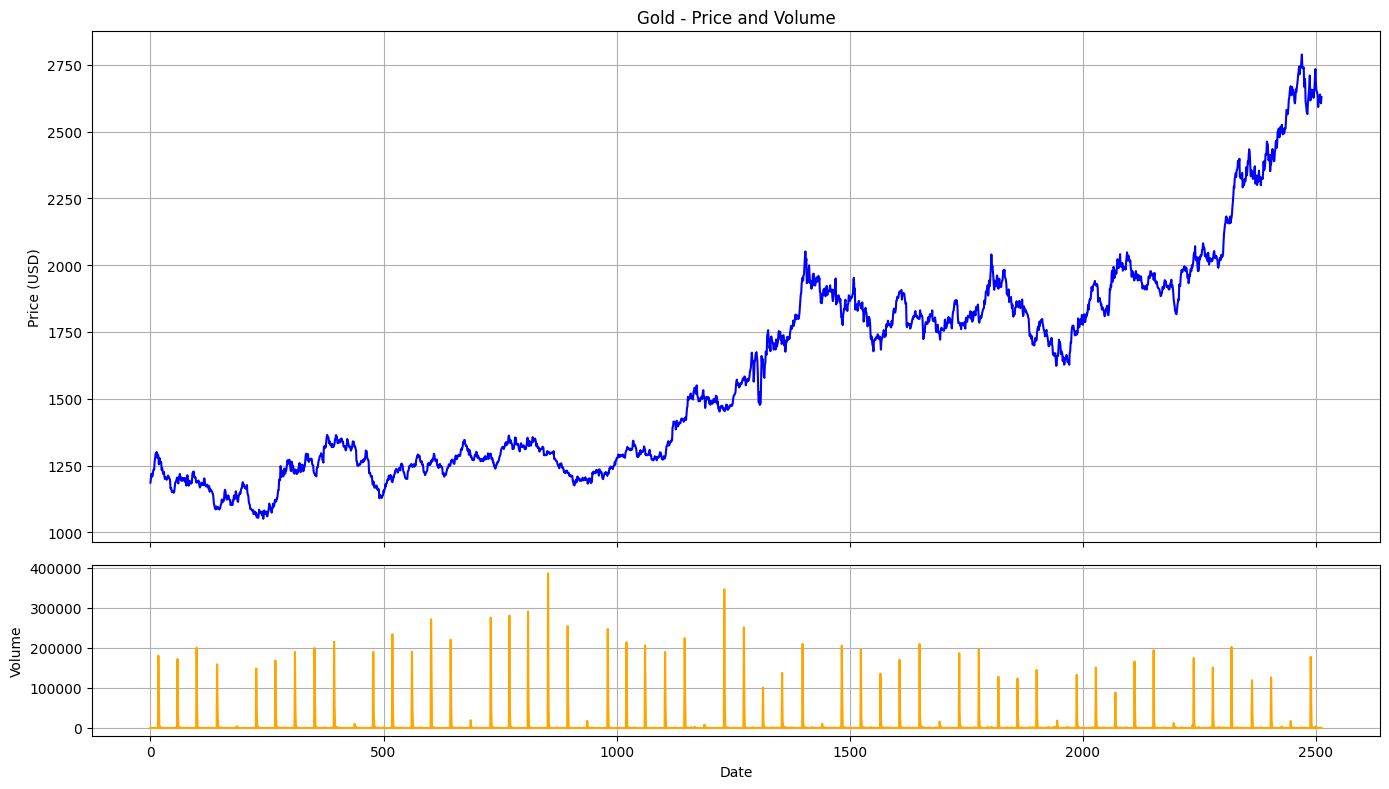

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price line (top)
ax1.plot(aux.index, aux['GOLD'], label='Price', color='blue')
ax1.set_ylabel('Price (USD)')
ax1.set_title('Gold - Price and Volume')
ax1.grid(True)

# Volume line (bottom)
ax2.plot(aux.index, aux['Volume'], label='Volume', color='orange')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

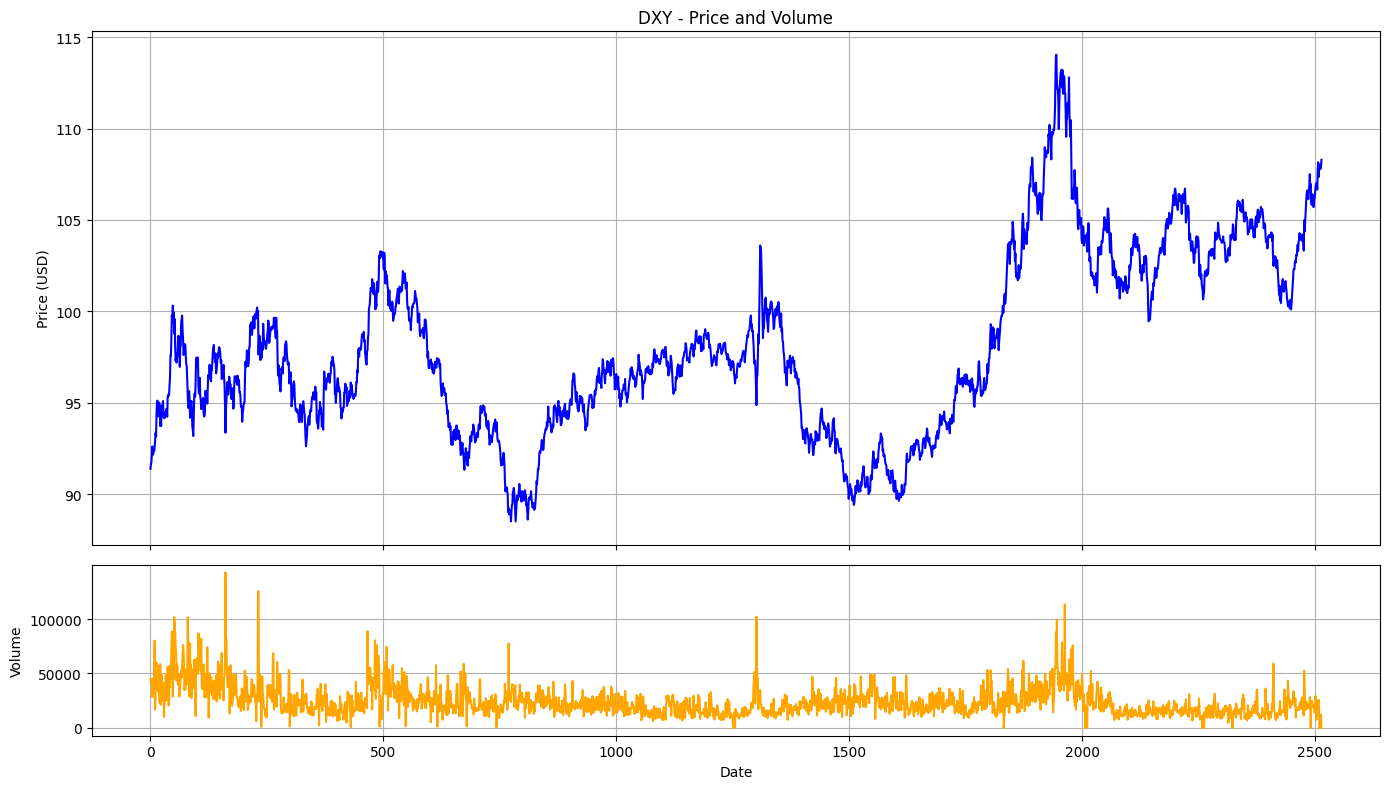

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price line (top)
ax1.plot(dxy.index, dxy['DXY'], label='Price', color='blue')
ax1.set_ylabel('Price (USD)')
ax1.set_title('DXY - Price and Volume')
ax1.grid(True)

# Volume line (bottom)
ax2.plot(dxy.index, dxy['Volume'], label='Volume', color='orange')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

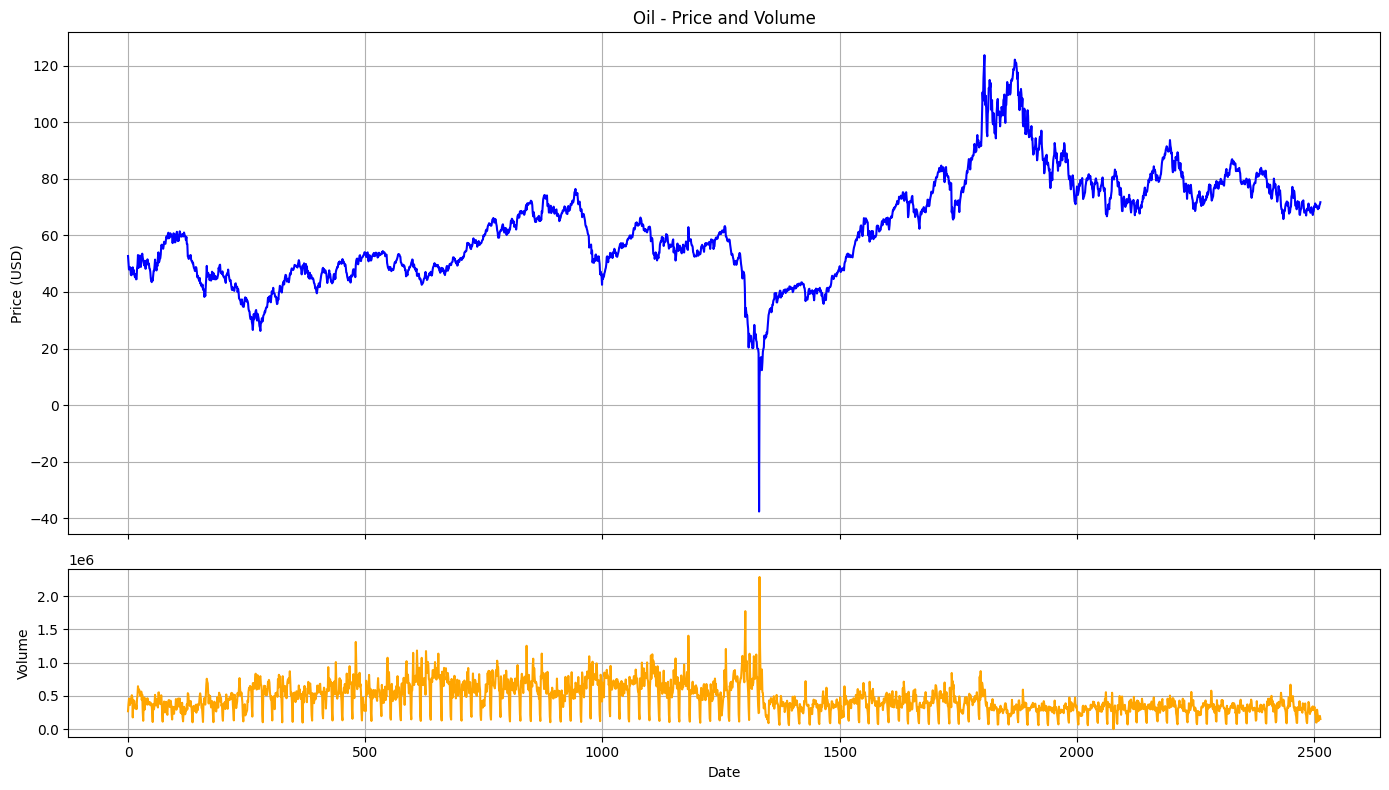

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price line (top)
ax1.plot(oil.index, oil['OIL'], label='Price', color='blue')
ax1.set_ylabel('Price (USD)')
ax1.set_title('Oil - Price and Volume')
ax1.grid(True)

# Volume line (bottom)
ax2.plot(oil.index, oil['Volume'], label='Volume', color='orange')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

# AUX

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
aux['aux_scaled'] = scaler.fit_transform(np.array(aux['GOLD']).reshape(-1, 1))
auxdf = aux[['Date', 'aux_scaled']].copy()
aux, auxdf

(           Date         GOLD  Volume  aux_scaled
 0    2005-01-03   428.700012       4    0.006776
 1    2005-01-04   428.500000     108    0.006692
 2    2005-01-05   426.600006       2    0.005893
 3    2005-01-06   421.000000       1    0.003535
 4    2005-01-07   418.899994       1    0.002652
 ...         ...          ...     ...         ...
 5021 2024-12-24  2620.000000      35    0.929080
 5022 2024-12-26  2638.800049      84    0.936992
 5023 2024-12-27  2617.199951     642    0.927901
 5024 2024-12-30  2606.100098     794    0.923229
 5025 2024-12-31  2629.199951     401    0.932952
 
 [5026 rows x 4 columns],
            Date  aux_scaled
 0    2005-01-03    0.006776
 1    2005-01-04    0.006692
 2    2005-01-05    0.005893
 3    2005-01-06    0.003535
 4    2005-01-07    0.002652
 ...         ...         ...
 5021 2024-12-24    0.929080
 5022 2024-12-26    0.936992
 5023 2024-12-27    0.927901
 5024 2024-12-30    0.923229
 5025 2024-12-31    0.932952
 
 [5026 rows x 2 column

## Train and test data

In [4]:
split_index = int(len(auxdf) * 0.8)

train_data = auxdf.iloc[:split_index]
test_data = auxdf.iloc[split_index:]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (4020, 2)
test_data:  (1006, 2)


In [5]:
train_data

,Date,aux_scaled
0,2005-01-03,0.006776
1,2005-01-04,0.006692
2,2005-01-05,0.005893
3,2005-01-06,0.003535
4,2005-01-07,0.002652
...,...,...
4015,2020-12-23,0.615388
4016,2020-12-24,0.617577
4017,2020-12-28,0.616440
4018,2020-12-29,0.617492


## Grid search SVR

Search for time window

In [6]:
def window(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


Trend follow directional loss

In [7]:
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

In [8]:
loss_functions = {
    "MAE": mean_absolute_error,
    "MSE": mean_squared_error,
    "Directional Accuracy": directional_accuracy
}

Grid

In [9]:
window_sizes = np.linspace(15, 100, 10, dtype=int)
C_values = np.logspace(2, -1, 10)  # 100 → 0.1


🔹 MAE
  Best Window Size: 15
  Best C: 100.000
  Loss: 0.14026


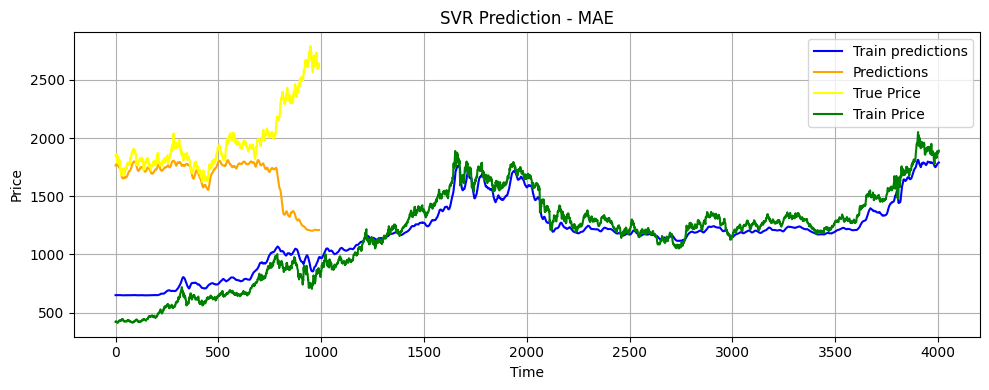


🔹 MSE
  Best Window Size: 15
  Best C: 100.000
  Loss: 0.05452


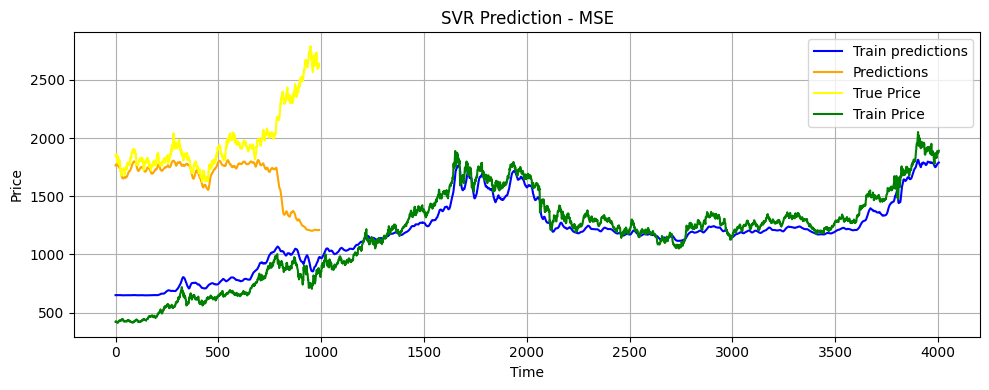


🔹 Directional Accuracy
  Best Window Size: 24
  Best C: 0.100
  Loss: 0.51274


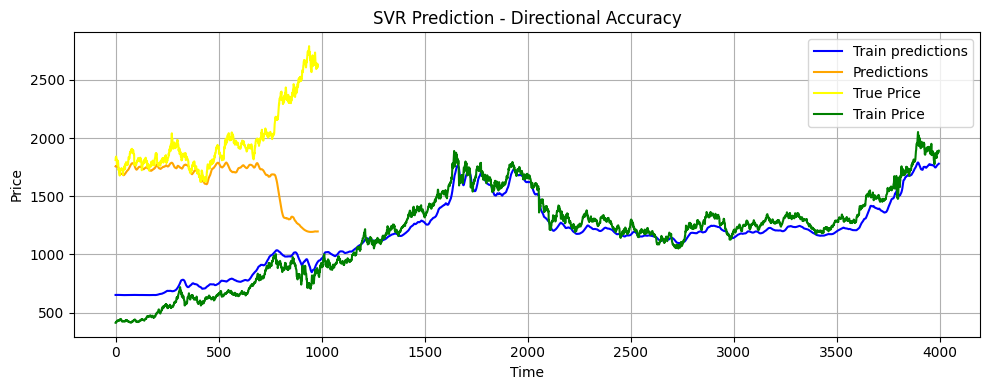

In [10]:
best_results = {}

for loss_name, loss_fn in loss_functions.items():
    best_loss = float("inf") if loss_name != "Directional Accuracy" else -1
    best_model_data = {}

    for window_size, C in itertools.product(window_sizes, C_values):
        X_train, y_train = window(train_data['aux_scaled'], window_size)
        X_test, y_test = window(test_data['aux_scaled'], window_size)
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        model = SVR(kernel="rbf", C=C)
        model.fit(X_train, y_train)
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        loss = loss_fn(y_test, test_predict)
        if (loss_name == "Directional Accuracy" and loss > best_loss) or \
           (loss_name != "Directional Accuracy" and loss < best_loss):
            best_loss = loss
            best_model_data = {
                "params": {"window_size": window_size, "C": C},
                "test_predict": test_predict,
                "y_test": y_test,
                "train_predict": train_predict,
                "y_train": y_train
            }

    best_results[loss_name] = {
        "loss": best_loss,
        **best_model_data
    }

# === Results + Plots ===
for loss_name, result in best_results.items():
    print(f"\n🔹 {loss_name}")
    print(f"  Best Window Size: {result['params']['window_size']}")
    print(f"  Best C: {result['params']['C']:.3f}")
    print(f"  Loss: {result['loss']:.5f}")

    train_predict_inv = scaler.inverse_transform(result['train_predict'].reshape(-1, 1)).flatten()
    test_predict_inv = scaler.inverse_transform(result['test_predict'].reshape(-1, 1)).flatten()
    y_train_inv = scaler.inverse_transform(result['y_train'].reshape(-1, 1)).flatten()
    y_test_inv = scaler.inverse_transform(result['y_test'].reshape(-1, 1)).flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(train_predict_inv, c='blue', label='Train predictions')
    plt.plot(test_predict_inv, c='orange', label='Predictions')
    plt.plot(y_test_inv,c='yellow', label='True Price')
    plt.plot(y_train_inv, c='green', label='Train Price')
    plt.title(f"SVR Prediction - {loss_name}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Random forest

In [11]:
from sklearn.ensemble import RandomForestRegressor